## 3. 使用 RNN 构建语言模型

### 环境说明：

In [1]:
%load_ext watermark
%watermark -a 'Scott Ming' -v -m -d -p numpy,pandas,matplotlib,tensorflow

Scott Ming 2017-04-23 

CPython 3.6.0
IPython 6.0.0

numpy 1.12.1
pandas 0.19.2
matplotlib 2.0.0
tensorflow 1.0.1

compiler   : GCC 4.9.2
system     : Linux
release    : 3.16.0-4-amd64
machine    : x86_64
processor  : 
CPU cores  : 4
interpreter: 64bit


In [2]:
%matplotlib inline

import itertools
import operator
import re
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import jieba
import tensorflow as tf
import zhon.hanzi as zh

### 1. 数据清理

In [3]:
def read_data(filename):
    """Read and cut sequences, return a long string."""
    jieba.setLogLevel(20)
    jieba.enable_parallel(4)
    with open(filename, 'r') as file:
        data = file.read()
    # Split sequences with zh.punctuation or 'new line'
    sequences = re.split(r'[{}|\n]'.format(zh.punctuation), data)
    # Remove empty string
    sequences = (sequence for sequence in sequences if sequence)
    sequences = (list(jieba.cut(sequence)) for sequence in sequences)
    return sequences

In [4]:
def get_common_words(words, n):
    count = Counter(words)
    count_dict = {i: j for i, j in count.items() if j > n}
    word_counts = sorted(count_dict.items(), key=operator.itemgetter(1), reverse=True)
    return word_counts

In [5]:
def build_dict(word_counts):
    count = [['UNK', -1]]
    count.extend(word_counts)
    word_dict = {key: value for value, (key, _) in enumerate(count)}
    reversed_dict = {key: value for value, key in word_dict.items()}
    return word_dict, reversed_dict

In [6]:
def word_to_number(sequences, word_dict):
    data = []
    for sequence in sequences:
        sequence_data = []
        for word in sequence:
            if word in word_dict:
                index = word_dict[word]
            else:
                index = 0
            sequence_data.append(index)
        data.append(sequence_data)
    return data

In [7]:
data = list(read_data('YGZ-rain.md'))

In [8]:
words = list(itertools.chain.from_iterable(data))

In [9]:
word_counts = get_common_words(words, 0)  # 小语料训练，所以不做截断了

In [10]:
word_dict, reversed_dict = build_dict(word_counts)

In [11]:
text_data = word_to_number(data, word_dict)

### 0. 定义参数

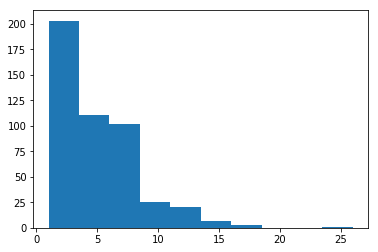

In [12]:
length = [len(i) for i in text_data]
plt.hist(length)
plt.show()

大部分句子长度都在10以下

In [13]:
vocab_size = len(word_counts) + 1  # 1214
hidden_size = 128  # The same as embedding dim
batch_size = 20
max_words = 10
number_steps = max_words - 1
epochs = 1000 + 1
print_loss_every = 100
eval_every = 200
lr = 0.01

### 1. 定义测试数据

In [14]:
data_padding = np.asarray([x[:max_words] for x in [y + [0] * max_words 
                                         for y in text_data]])

In [15]:
x = data_padding[:, :number_steps]
y_ = data_padding[:, 1:]
train_data = np.concatenate((x, y_), axis=1)  # 方便 shuffle

### 2. 定义 RNN 类

In [16]:
class BasicRNN(object):
    def __init__(self, number_steps, vocab_size, hidden_size, batch_size, infer_sample=False):
        self.number_steps = number_steps
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size  # Equal to embeddings dim
        self.batch_size = batch_size 
        
        if infer_sample:
            self.batch_size = 1
            self.number_steps = 1
        else:
            self.batch_size = batch_size
            self.number_steps = number_steps

        # Placeholder for input, output
        self.input_x = tf.placeholder(tf.int32, shape=[None, self.number_steps], name='input_x')
        self.input_y = tf.placeholder(tf.int32, shape=[None, self.number_steps], name='input_y')
        # 先把非零元素转为 1，然后求和，即句子长度，当然原先句子中的一些 unk 也被忽略了
        self.sequence_length = tf.reduce_sum(tf.sign(self.input_x), 1)
        
        # Embedding layer
        with tf.name_scope('embedding'):
            word_embedding = tf.get_variable('word_embedding', [self.vocab_size, self.hidden_size],
                                            tf.float32, tf.random_normal_initializer())
            embeds = tf.nn.embedding_lookup(word_embedding, self.input_x)
        
        # RNN layer
        with tf.name_scope('rnn'):
            self.basic_cell = tf.contrib.rnn.BasicRNNCell(self.hidden_size)
            self.initial_state = self.basic_cell.zero_state(self.batch_size, tf.float32)
            outputs, states = tf.nn.dynamic_rnn(
                self.basic_cell, embeds, dtype=tf.float32, sequence_length=self.sequence_length)
            # Flat outputs
            output_flat = tf.reshape(outputs, [-1, self.hidden_size])
            self.final_state = states
        
        # Softmax output
        with tf.name_scope('softmax_output'):
            W = tf.get_variable('W', [self.hidden_size, self.vocab_size], 
                                tf.float32, tf.random_normal_initializer())
            b = tf.get_variable('b', [self.vocab_size], tf.float32, 
                                tf.constant_initializer(0.0))
            self.logits = tf.matmul(output_flat, W) + b
            self.model_output = tf.nn.softmax(self.logits)
        
        # Cross-entropy loss
        with tf.name_scope('loss'):
            labels_flat = tf.reshape(self.input_y, [-1])
            mask = tf.cast(tf.sign(labels_flat), dtype=tf.float32)
            cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=labels_flat)
            self.loss = tf.reduce_sum(cost * mask) / batch_size  # 每个句子的平均损失

    def sample(self, sess, words=reversed_dict, vocab=word_dict, num=10, prime_text='听听 那冷雨'):
        state = sess.run(self.basic_cell.zero_state(1, tf.float32))
        word_list = prime_text.split()
        for word in word_list[:-1]:
            x = np.zeros((1, 1))
            x[0, 0] = vocab[word]
            feed_dict = {self.input_x: x, self.initial_state:state}
            [state] = sess.run([self.final_state], feed_dict=feed_dict)

        out_sentence = prime_text
        word = word_list[-1]
        for n in range(num):
            x = np.zeros((1, 1))
            x[0, 0] = vocab[word]
            feed_dict = {self.input_x: x, self.initial_state: state}
            [model_output, state] = sess.run([self.model_output, self.final_state], feed_dict=feed_dict)
            sample = np.argmax(model_output[0])
            if sample == 0:
                break
            word = words[sample]
            out_sentence = out_sentence + ' ' + word
        return out_sentence

In [17]:
rnn = BasicRNN(number_steps, vocab_size, hidden_size, batch_size)

### 3. 训练模型

In [18]:
train_step = tf.train.AdamOptimizer(lr).minimize(rnn.loss)
saver = tf.train.Saver()
with tf.Session() as sess:
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):
        test_basic_model = BasicRNN(
            number_steps, vocab_size, hidden_size, 
            batch_size, infer_sample=True)
    costs = 0.0
    iters = 0
    sess.run(tf.global_variables_initializer())
    for i in range(epochs): 
        batch_data = train_data[np.random.randint(
            train_data.shape[0], size=batch_size), :]
        X = batch_data[:, :number_steps]
        Y = batch_data[:, number_steps:]
        feed_dict = {rnn.input_x: X, rnn.input_y: Y}
        sess.run(train_step, feed_dict=feed_dict)
        cross_entropy = sess.run(rnn.loss, feed_dict=feed_dict)
        costs += cross_entropy
        iters += number_steps
        perplexity = np.exp(costs / iters)
        if i % print_loss_every == 0 and i != 0:
            print('After {:4d} steps, perplexity is {:.2f}'.format(i, perplexity))
        if i % eval_every == 0 and i != 0:
            print(test_basic_model.sample(sess, num=10))
            print('=-=' * 12)
    # After training, save the final sess
    saver.save(sess, 'save_model/rnn-model.ckpt', global_step=epochs)

After  100 steps, perplexity is 14.38
After  200 steps, perplexity is 4.67
听听 那冷雨 雨滴 椽 的 意趣 两次 神州 的 意趣 两次 神州
=-==-==-==-==-==-==-==-==-==-==-==-=
After  300 steps, perplexity is 2.97
After  400 steps, perplexity is 2.34
听听 那冷雨 在 日式 的 境界 水迢 的 境界 水迢 的 境界
=-==-==-==-==-==-==-==-==-==-==-==-=
After  500 steps, perplexity is 2.03
After  600 steps, perplexity is 1.84
听听 那冷雨 在 旭日 在 旭日 在 旭日 在 旭日 在 旭日
=-==-==-==-==-==-==-==-==-==-==-==-=
After  700 steps, perplexity is 1.71
After  800 steps, perplexity is 1.62
听听 那冷雨 着 星期三 飘云 在 古老 的 意趣 毕竟 是 一种
=-==-==-==-==-==-==-==-==-==-==-==-=
After  900 steps, perplexity is 1.56
After 1000 steps, perplexity is 1.50
听听 那冷雨 在 石 秋 雨潇潇 台风 台雨 在 石 秋 雨潇潇
=-==-==-==-==-==-==-==-==-==-==-==-=


## Refrences:

* [assignment2.pdf](http://web.stanford.edu/class/cs224n/assignment2/assignment2.pdf)
* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)